This script is dedicated to explore the departments (de: Ressort) with relation to the author mapping.

In [17]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import re
import tqdm
from src.models.MatchingType import MatchingType

In [18]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [24]:
# get top 30 authors with the most articles
rows = cur.execute('select distinct(name) from unmapped_authors where matching_type = ? or matching_type = ? group by name order by count(*) desc limit 30', (MatchingType.DIRECT_MATCH.name, MatchingType.FUZZY_MATCH.name)).fetchall()
authors = [row[0] for row in rows]

In [25]:
# remove  None from authors
authors = [author for author in authors if author is not None]

In [43]:
authors

['Jens Rosenkranz',
 'Robert Nößler',
 'Matthias Puppe',
 'Josephine Heinze',
 'Evelyn ter Vehn',
 'Ekkehard Schulreich',
 'Matthias Roth',
 'Claudia Carell',
 'Marc Bohländer',
 'Michael Frömmert',
 'Anne Grimm',
 'Clemens Haug',
 'Christin Grödel',
 'Thomas Haegeler',
 'Reik Anton',
 'Christian Neffe',
 'Antje Henselin-Rudolph',
 'Susanne Weidner',
 'Gina Apitz',
 'Thomas Sparrer',
 'Ines Christ',
 'Nico Fliegner',
 'Christiane Lösch',
 'Anton Zirk',
 'Olaf Krenz',
 'Christine Jacob',
 'Stephan Lohse',
 'Manfred Hainich',
 'Steffen Brost',
 'Manuela Engelmann-Bunk']

In [27]:
json_authors = [json.dumps(author) for author in authors]

In [29]:
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name FROM articles ar join unmapped_article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()

In [30]:
departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name'], data=rows)

In [31]:
departments

,id,department,published_at,name
0,1526,"[""Region"", ""Doebeln""]",2021-12-10T09:00:28+00:00,Thomas Sparrer
1,1539,"[""Region"", ""Altenburg""]",2021-12-10T11:33:00+00:00,Jens Rosenkranz
2,1542,"[""Nachrichten"", ""Kultur"", ""Kultur-Regional""]",2021-12-10T12:02:00+00:00,Christian Neffe
3,1547,"[""Region"", ""Geithain""]",2021-12-10T12:52:02+00:00,Ekkehard Schulreich
4,1552,"[""Region"", ""Delitzsch""]",2021-12-10T13:28:00+00:00,Christine Jacob
...,...,...,...,...
40465,367631,"[""Nachrichten"", ""Kultur""]",2010-01-04T14:34:18+00:00,Matthias Puppe
40466,367636,"[""Region"", ""Delitzsch""]",2010-01-04T15:41:49+00:00,Nico Fliegner
40467,367639,"[""Region"", ""Bad-Dueben""]",2010-01-04T16:01:56+00:00,Nico Fliegner
40468,367690,"[""Region"", ""Bad-Dueben""]",2010-01-01T12:41:42+00:00,Nico Fliegner


In [32]:
departments["department"] = departments["department"].apply(lambda x: json.loads(x))

In [33]:
departments = departments.explode('department')

In [34]:
# remove rows where department equals "Region" or "Nachrichten" for being to unspecific
departments = departments[departments.department != 'Region']
departments = departments[departments.department != 'Nachrichten']
departments

,id,department,published_at,name
0,1526,Doebeln,2021-12-10T09:00:28+00:00,Thomas Sparrer
1,1539,Altenburg,2021-12-10T11:33:00+00:00,Jens Rosenkranz
2,1542,Kultur,2021-12-10T12:02:00+00:00,Christian Neffe
2,1542,Kultur-Regional,2021-12-10T12:02:00+00:00,Christian Neffe
3,1547,Geithain,2021-12-10T12:52:02+00:00,Ekkehard Schulreich
...,...,...,...,...
40465,367631,Kultur,2010-01-04T14:34:18+00:00,Matthias Puppe
40466,367636,Delitzsch,2010-01-04T15:41:49+00:00,Nico Fliegner
40467,367639,Bad-Dueben,2010-01-04T16:01:56+00:00,Nico Fliegner
40468,367690,Bad-Dueben,2010-01-01T12:41:42+00:00,Nico Fliegner


In [35]:
# create pandas data frame with author name and their department in that they wrote the most articles
author_departments = departments.groupby(['name', 'department']).agg('count').sort_values(by='id', ascending=False).reset_index()
# for each author get row with highest count
author_departments = author_departments.groupby('name').head(1)
# drop column id
author_departments = author_departments.drop(columns=['id'])
# rename column published_at to article_count
author_departments = author_departments.rename(columns={'published_at': 'article_count'})

In [36]:
author_departments

,name,department,article_count
0,Ekkehard Schulreich,Geithain,3407
1,Christine Jacob,Delitzsch,2411
2,Thomas Sparrer,Doebeln,2188
3,Matthias Puppe,Leipzig,1810
4,Jens Rosenkranz,Leipzig,1711
5,Evelyn ter Vehn,Leipzig,1688
6,Thomas Haegeler,Altenburg,1665
8,Olaf Krenz,Borna,1485
9,Steffen Brost,Bad-Dueben,1418
10,Josephine Heinze,Leipzig,1217


In [41]:
# get articles with authors that are in the top 30
rows = cur.execute("SELECT ar.id, a.name FROM articles ar join unmapped_article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.name in " + '(' + ','.join(json_authors) + ')').fetchall()
authors_with_articles = pd.DataFrame(columns=['id', 'name'], data=rows)

# remove the rows where the id does not occur in the whole dataframe more than once
# that means we remove articles that do not have more than one author
authors_with_articles = authors_with_articles[authors_with_articles.id.isin(authors_with_articles.id.value_counts()[authors_with_articles.id.value_counts() > 1].index)]
authors_with_articles

,id,name
20,1786,Thomas Haegeler
21,1786,Jens Rosenkranz
47,2127,Jens Rosenkranz
48,2127,Thomas Haegeler
71,2444,Jens Rosenkranz
...,...,...
39944,363339,Matthias Roth
40083,364262,Steffen Brost
40084,364262,Nico Fliegner
40382,366854,Nico Fliegner


In [40]:
authors_with_articles[authors_with_articles["id"].isin(authors_with_articles[authors_with_articles["name"] == "Jens Rosenkranz"]["id"].tolist())]

,id,name
20,1786,Thomas Haegeler
21,1786,Jens Rosenkranz
47,2127,Jens Rosenkranz
48,2127,Thomas Haegeler
71,2444,Jens Rosenkranz
...,...,...
37241,343816,Matthias Roth
38137,350020,Ines Christ
38138,350020,Jens Rosenkranz
39390,358852,Jens Rosenkranz


In [42]:
len(authors_with_articles.groupby('id').groups)

805

In [39]:
edges = authors_with_articles.groupby('id')['name'].apply(list).tolist()
edges

[['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Thomas Haegeler', 'Jens Rosenkranz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Anton Zirk', 'Josephine Heinze'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Thomas Sparrer', 'Manuela Engelmann-Bunk'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Matthias Puppe', 'Anton Zirk'],
 ['Anton Zirk', 'Matthias Puppe'],
 ['Steffen Brost', 'Christine Jacob'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Anton Zirk', 'Matthias Roth'],
 ['Matthias Puppe', 'Josephine Heinze'],
 ['Jens Rosenkranz', 'Thomas Haegeler'],
 ['Ekkehard Schulreich', 'Olaf Krenz'],

In [21]:
# print len edges
print(len(edges))

1189


In [22]:
# remove edges with more than 2 names just for the simplicity of the evaluation
modified_edges = []
for edge in edges:
    if len(edge) > 2:
        for i in range(len(edge)):
            for j in range(i+1, len(edge)):
                modified_edges.append([edge[i], edge[j]])
    else:
        modified_edges.append(edge)

In [23]:
edges = modified_edges

In [ ]:
static_color_map = {'Altenburg': (0.984313725490196, 0.6039215686274509, 0.6),
 'Bad-Dueben': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 'Borna': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 'Delitzsch': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'Doebeln': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'Eilenburg': (1.0, 1.0, 0.6),
 'Geithain': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Grimma': (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 'Kultur': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 'Leipzig': (0.2, 0.6274509803921569, 0.17254901960784313),
 'Mitteldeutschland': (0.6980392156862745, 0.8745098039215686, .5411764705882353),
 'Schkeuditz': (1.0, 0.4980392156862745, 0.0),
 'Specials': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'Sportbuzzer': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'Wurzen': (0.792156862745098, 0.6980392156862745, 0.8392156862745098)}

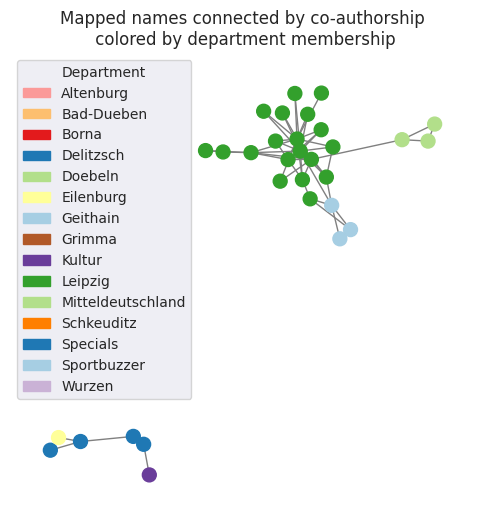

In [37]:
graph = nx.Graph()
graph.clear()

# Count the occurrences of each edge
edge_counts = {}
for edge in edges:
    key = tuple(sorted(edge))
    edge_counts[key] = edge_counts.get(key, 0) + 1

color_map = []

# Add nodes and weighted edges to the graph
for edge, count in edge_counts.items():
    node1, node2 = edge
    if count < 5:
        continue
    if not graph.has_node(node1):
        graph.add_node(node1)
        # add a color to the node
        color_map.append(static_color_map[author_departments[author_departments.name == node1].department.values[0]])
    if not graph.has_node(node2):
        graph.add_node(node2)
        # add a color to the node
        color_map.append(static_color_map[author_departments[author_departments.name == node1].department.values[0]])
    graph.add_edge(node1, node2, weight=count)

# display graph
plt.figure(figsize=[6, 6])
plt.title('Mapped names connected by co-authorship\n colored by department membership')
nx.draw(graph, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')
# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in static_color_map.items()]
plt.legend(handles=legend_patches, title='Department', loc='upper left')
plt.savefig('../reports/figures/department_exploration/mapped_names_co_authors_department_membership.png', dpi=200)

It looks very similar to the abbreviations figure. That means that the mapping is already quite good and we could further take into account the department membership. 
(We do see a slightly different figure for the abbreviations because the articles we choose to base co-authorship on for this example are different articles because they are those connected to the abbreviations (DIRECT_MATCH, FUZZY_MATCH) and not to the authors (IS_FULL_NAME).